### **CC57 - MACHINE LEARNING - APRENDIZAJE SEMI-SUPERVISADO CON CLUSTERING**

Se utiliza cuando todos los datos no están etiquetados.

Se trabajara con un conjuento de datos de digitos manunscritos cargado desde sklearn.datasets

In [ ]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#se cargan los datos, en X las variables independientes y en "y" la etiqueta o variable dependiente
X, y = load_digits(return_X_y=True)
print(X.shape, y.shape)

(1797, 64) (1797,)


<ipython-input-3-5e89ce452b38>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(5, 10, i+1)


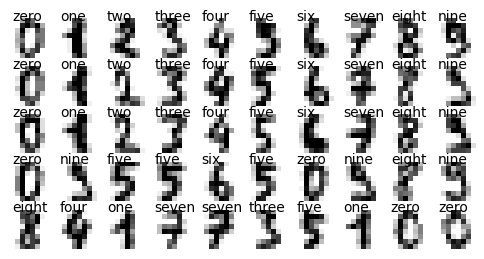

In [ ]:
#Visualizamos los primereos 50 digitos del conjunto de datos
plt.subplots(figsize=(6, 3))
labels = ["zero", "one", "two", "three", "four",
          "five", "six", "seven", "eight", "nine"]
for i in range(50):
    ax = plt.subplot(5, 10, i+1)
    idx = i
    ax.axis('off')
    ax.imshow(X[idx].reshape((8, 8)), cmap='gray_r')
    ax.text(0, 0, labels[int(y[idx])])
plt.show()

In [ ]:
#Dividimos el conjunto de datos en conjunto de entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1347, 64) (1347,)
(450, 64) (450,)


In [ ]:
#Creamos un clasificador de regresion logistica
lr = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=5000, random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [ ]:
#Evaluamos el la precision del clasificador de regresion logistica
lrscore = lr.score(X_test, y_test)
lrscore

0.9688888888888889

In [ ]:
#Ahora ejecutamos en un orden secuencial un clasificador kmeans y luego el de regresion logistica
pipeline = Pipeline([
    ('kmeans', KMeans(n_clusters=50, random_state=42)),
    ('lr', LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=5000, random_state=42))
])
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('kmeans', KMeans(n_clusters=50, random_state=42)),
                ('lr',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [ ]:
#Evaluamos la precision del clasificador doble canalizado
pipeline_score = pipeline.score(X_test, y_test)
pipeline_score

0.9777777777777777

In [ ]:
# Existe una mejora en presicion con respecto a solo utilizar el calsificador de regresion logistica
1 - (1 - pipeline_score) / (1 - lrscore)

0.28571428571428414

## **Tecnica de Aprendizaje Semi-superviseda**

In [ ]:
#Se crean 100 clusters y se obtienen los digitos mas representativos del conjunto de entranamiento
k = 100
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
X_digits_dist = kmeans.fit_transform(X_train)
#np.argmin: Devuelve los índices de los valores mínimos a lo largo de un eje
# (los que estan mas cerca al centroide)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

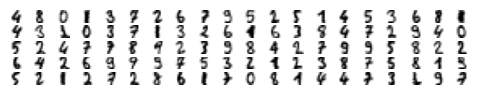

In [ ]:
#Visualizamos los digitos mas representativos
plt.figure(figsize=(6, 4))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 5, 20, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap='binary', interpolation='bilinear')
    #plt.title(f"{y_train[representative_digit_idx[index]]}")
    plt.axis('off')
plt.show()

Hemos creado 100 grupos con la esperanza de que cada uno de los 10 dígitos del 0 al 9 sea el más común en al menos 1 de los 100. Como podemos ver en la imagen anterior, cada dígito es el más representativo más de una vez.  Probar con un k = 50.

A partir de los dígitos representativos, creamos manualmente una matriz de etiquetas para entrenar un clasificador.

In [ ]:
y_byhand = np.array([
    4, 8, 0, 1, 3, 7, 2, 6, 7, 9, 5, 2, 5, 1, 4, 5, 3, 6, 8, 1,
    4, 3, 1, 0, 3, 7, 1, 3, 2, 6, 1, 6, 3, 8, 4, 7, 2, 9, 4, 0,
    5, 2, 4, 7, 7, 8, 9, 2, 3, 9, 8, 4, 2, 7, 9, 9, 5, 8, 2, 2,
    6, 4, 2, 6, 9, 9, 9, 7, 5, 3, 2, 1, 2, 3, 8, 7, 5, 8, 1, 9,
    5, 2, 1, 2, 7, 2, 8, 6, 1, 7, 0, 8, 1, 4, 4, 7, 3, 1, 9, 7,
])

In [ ]:
#Ahora, entrenamos el clasificador de regresion logistica con los digitos representativos obtenidos de la segmentacion anterior
lr = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=5000, random_state=42)
lr.fit(X_representative_digits, y_byhand)
lr.score(X_test, y_test)

0.9177777777777778

Propagar el dígito identificado a todas las demás instancias de cada grupo correspondiente,

In [ ]:
y_train_propagated = np.empty(len(X_train), dtype=int)
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_byhand[i]

In [ ]:
#Entrenamos nuevamente el clasificador de regresion logistica pero con la variable objetiva propagada y_train_propagated
lr = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=5000, random_state=42)
lr.fit(X_train, y_train_propagated)
lr.score(X_test, y_test)

0.96

Propagándose solo al percentil 75 de las instancias más cercanas al centroide de cada grupo

In [ ]:
percentile_closest = 75
X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [ ]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [ ]:
#Entrenamos nuevamente el clasificador de regresion logistica pero con la variable objetiva parcialmente propagada cercana al
# percentil 75 partially_propagated.  El entrenamiento se realiza con las variables X_train_partially_propagated, y_train_partially_propagated
lr = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=5000, random_state=42)
lr.fit(X_train_partially_propagated, y_train_partially_propagated)
lr.score(X_test, y_test)

0.9555555555555556

In [ ]:
#La media obtenida entre la variable objetivo propagada y la real
np.mean(y_train_propagated == y_train)

0.9747587230883444

In [ ]:
#La media obtenida entre la variable objetivo parcialmente propagada y la real parcialmente propagada
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.995

Observamos que tomando los datos mas cercanos al percentil 75 (de las instancias más cercanas al centroide de cada grupo) se logra una mejor precision.